# Explore corpus

In this notebook, we conduct an exploratory analysis of the corpus.

**Contents:**
1. Setup
2. Explore metadata
3. Explore abstracts
4. Explore fulltexts


## 1. Setup

Load dependencies and globals.

In [2]:
import pandas as pd
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from ast import literal_eval
from wordcloud import WordCloud, STOPWORDS
from collections import OrderedDict

GLOBALS = pickle.load(open('../data/globals.p', 'rb'))

Load metadata. 

In [3]:
metadata = pd.read_csv(GLOBALS['absolute_filepaths']['metadata'],
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str,
                              'in_range': bool, # FROM BUILD_CORPUS.IPYNB, PART 2
                              'has_xml': bool}, # FROM EXTRACT_AND_CONVERT_PAPERS.IPYNB 
                       parse_dates=['date_retrieved'])
corpus = metadata[metadata['has_xml'] & metadata['in_range']]
corpus['subcategories'] = corpus['subcategories'].apply(literal_eval) # cannot apply to metadata cuz of NaNs
print('Papers we have metadata for: ' + str(len(metadata)))
print('After filtering, corpus size: ' + str(len(corpus)))

Papers we have metadata for: 274402
After filtering, corpus size: 145437


/Users/briennakh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Specify subcategories.

In [4]:
astrophysics_subcats = {'astro-ph.SR': 'Solar and Stellar Astrophysics',
                        'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                        'astro-ph.GA': 'Astrophysics of Galaxies',
                        'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                        'astro-ph.EP': 'Earth and Planetary Astrophysics',
                        'astro-ph.IM': 'Instrumentation and Methods for Astrophysics'}

## 2. Category distribution

**View counts of all categories.**

In [173]:
all_cat_count = Counter(x for xs in corpus['categories'].str.split(' ') for x in set(xs))
all_cat_count

Counter({'hep-th': 7588,
         'astro-ph.CO': 44924,
         'gr-qc': 13452,
         'astro-ph.GA': 37270,
         'astro-ph.HE': 34036,
         'astro-ph.SR': 38090,
         'astro-ph.IM': 14174,
         'hep-ph': 11643,
         'astro-ph.EP': 14706,
         'physics.geo-ph': 366,
         'physics.ao-ph': 341,
         'physics.plasm-ph': 1672,
         'hep-ex': 1968,
         'nucl-th': 2249,
         'cs.DC': 121,
         'physics.chem-ph': 288,
         'physics.data-an': 420,
         'physics.ins-det': 1252,
         'nucl-ex': 767,
         'nlin.PS': 48,
         'physics.space-ph': 1665,
         'physics.flu-dyn': 882,
         'cs.CV': 87,
         'math.MP': 324,
         'math-ph': 324,
         'cond-mat.other': 63,
         'physics.gen-ph': 43,
         'physics.comp-ph': 525,
         'quant-ph': 284,
         'cond-mat.stat-mech': 199,
         'physics.class-ph': 91,
         'physics.atom-ph': 355,
         'math.GT': 3,
         'stat.AP': 197,
      

**View subcategory counts within the corpus.**

In [172]:
subcat_count = Counter(x for xs in corpus['subcategories'] for x in set(xs))
subcat_count

Counter({'astro-ph.CO': 44924,
         'astro-ph.GA': 37270,
         'astro-ph.HE': 34036,
         'astro-ph.SR': 38090,
         'astro-ph.IM': 14174,
         'astro-ph.EP': 14706})

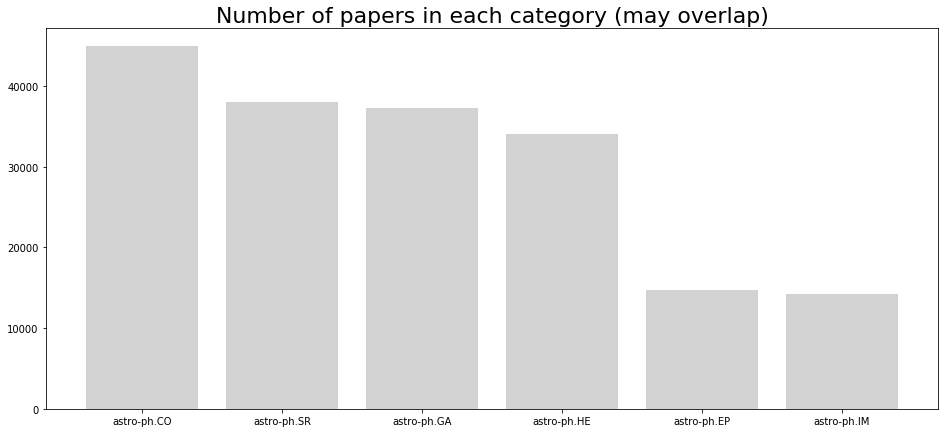

In [430]:
plt.figure(figsize=(16,7))
plt.bar(subcat_count.keys(), subcat_count.values, color='lightgray')
plt.title('Number of papers in each category (may overlap)', fontdict=dict(size=22))
#plt.text(4.5, 50000, str(len(corpus)) + ' papers', size=14, color='darkgray')
plt.show()

**Visualize number of category distribution.**

In [176]:
corpus['subcategories'].apply(lambda x: len(x)).value_counts().sort_values(ascending=False)

1    111209
2     30965
3      3039
4       180
5        40
6         4
Name: subcategories, dtype: int64

**Visualize the number of papers that have subcategory X and Y.**

In [129]:
papers = corpus['subcategories']
names = astrophysics_subcats.keys()

occurrences = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)

for l in papers:
    if len(l) == 1: # if only one category, upcount itself
        occurrences[l[0]][l[0]] += 1
        continue
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            if item in names:
                occurrences[l[i]][item] += 1
                
mapped_data = pd.DataFrame.from_dict(occurrences)
mapped_data

,astro-ph.SR,astro-ph.CO,astro-ph.GA,astro-ph.HE,astro-ph.EP,astro-ph.IM
astro-ph.SR,23299,941,6176,4103,3989,1784
astro-ph.CO,941,30998,8320,4446,140,2002
astro-ph.GA,6176,8320,19183,4135,651,1488
astro-ph.HE,4103,4446,4135,21182,247,1950
astro-ph.EP,3989,140,651,247,9391,1250
astro-ph.IM,1784,2002,1488,1950,1250,7156


*Note: `mapped_data['astro-ph.SR'].sum()` will not equal `subcat_count['astro-ph.SR']` cuz the latter counts how many times astro-ph.SR appears in the corpus, counting each qualifying paper only once, whereas the former counts for EACH paper the different combinations of categories. For example if a paper has three categories, astro-ph.SR, astro-ph.GA, astro-ph.EP, then `mapped_data['astro-ph.SR']` would gain 2 counts in its data row, one for astro-ph.GA, and one for astro-ph.EP.*

In [25]:
mapped_data_count = mapped_data.sum(axis=0).sort_values(ascending=False)
print('Co-occurrences of astro-ph.SR in corpus: ' + str(mapped_data['astro-ph.SR'].sum()))
print('Number of papers with astro-ph.SR : ' + str(subcat_count['astro-ph.SR']))

Co-occurrences of astro-ph.SR in corpus: 40292
Number of papers with astro-ph.SR : 38090


Confirm the reason for the difference by checking astro-ph.SR.

In [16]:
has_SR = corpus[corpus['subcategories'].apply(lambda x: 'astro-ph.SR' in x)]
print('All papers that have astro-ph.SR: ' + str(len(has_SR)))
counts_SR = has_SR[has_SR['subcategories'].apply(lambda x: len(x)) > 2]['subcategories'].apply(lambda x: len(x)).value_counts()
keys = counts_SR.keys()
total = 0
for i in range(len(keys)):
    # Multiply papers that have 3 categories by 2, as it would add 2 occurrences to the first category's data row
    # and multiply papers that have 4 categories by 3, and so on
    total += counts_SR[keys[i]] * (keys[i] - 2)

print('Additional occurrences of astro-ph.SR based presence of 2+ categories: ' + str(total))
diff = int(mapped_data_count['astro-ph.SR'] - subcat_count['astro-ph.SR'])
equals_diff = total == diff
print('This equals difference between mapped_data[\'astro-ph.SR\'].sum() and subcat_count[\'astro-ph.SR\']: ' + str(equals_diff))

All papers that have astro-ph.SR: 38090
Additional occurrences of astro-ph.SR based presence of 2+ categories: 2202
This equals difference between mapped_data['astro-ph.SR'].sum() and subcat_count['astro-ph.SR']: True


Another way to check this is by looking at permutations. Essentially mapped_data shows us the permutations of categories.

In [159]:
print('Total permutations according to mapped_data: ' + str(mapped_data_count.sum()))
permutation_counts = corpus['subcategories'].apply(lambda x: len(list(itertools.permutations(x, 2)))).value_counts()
permutation_counts[1] = permutation_counts[0]
del permutation_counts[0]
permutation_counts.sort_values(ascending=False)

keys = permutation_counts.keys()
total_permutations = 0
for i in keys:
    total_permutations += permutation_counts[i] * i
total_permutations
print('Total calculated permutations: ' + str(total_permutations))

Total permutations according to mapped_data: 194453
Total calculated permutations: 194453


What is the most common subcategory co-occurrence?

In [162]:
m,n = mapped_data.shape
mapped_data2 = mapped_data
mapped_data2[:] = np.where(np.arange(m)[:,None] >= np.arange(n),0,mapped_data)
mapped_data2.stack().index[np.argmax(mapped_data2.values)]

('astro-ph.CO', 'astro-ph.GA')

We will use R to visualize this, in the notebook Generate_figures_in_R.ipynb, as there is [no specific library](https://python-graph-gallery.com/chord-diagram/) for chord diagrams in python. A chord will form between mapped_data[k][j] and mapped_data[j][k].

Set bottom half of matrix to zero, otherwise the chord diagram in R will have two chords for each link.

In [496]:
m,n = mapped_data.shape
mapped_data[:] = np.where(np.arange(m)[:,None] > np.arange(n),0,mapped_data)
mapped_data

,astro-ph.SR,astro-ph.CO,astro-ph.GA,astro-ph.HE,astro-ph.EP,astro-ph.IM
astro-ph.SR,23299,941,6176,4103,3989,1784
astro-ph.CO,0,30998,8320,4446,140,2002
astro-ph.GA,0,0,19183,4135,651,1488
astro-ph.HE,0,0,0,21182,247,1950
astro-ph.EP,0,0,0,0,9391,1250
astro-ph.IM,0,0,0,0,0,7156


Save to .rds, a file format that can be read easily by R.

In [497]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
     r_df = ro.conversion.py2ri(mapped_data)
        
# Save R dataframe as .rds file
r_file = "../data/category_cooccurrences.rds"
robjects.r.assign("category_cooccurrences", r_df)
robjects.r(f"saveRDS(category_cooccurrences, file='{r_file}')")

rpy2.rinterface.NULL

## 3. Abstracts

**Visualize abstract word count.**

In [11]:
abstracts = [abstract.replace('\n', ' ').strip() for abstract in corpus['abstract']]
abstracts_word_count = [len(abstract.split(' ')) for abstract in abstracts]

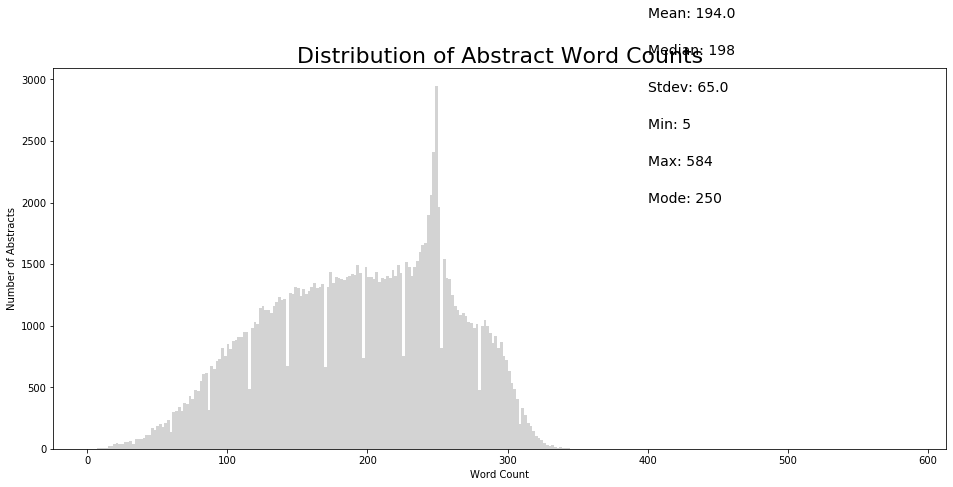

In [12]:
plt.figure(figsize=(16,7))
plt.hist(abstracts_word_count, bins=300, color='darkgray', alpha=0.5)
plt.text(400, 3500, "Mean: " + str(round(np.mean(abstracts_word_count))), size=14)
plt.text(400, 3200, "Median: " + str(int(round(np.median(abstracts_word_count)))), size=14)
plt.text(400, 2900, "Stdev: " + str(round(np.std(abstracts_word_count))), size=14)
plt.text(400, 2600, "Min: " + str(round(np.min(abstracts_word_count))), size=14)
plt.text(400, 2300, "Max: " + str(round(np.max(abstracts_word_count))), size=14)
plt.text(400, 2000, "Mode: " + str(stats.mode(abstracts_word_count)[0][0]), size=14)
plt.gca().set(ylabel='Number of Abstracts', xlabel='Word Count')
plt.title('Distribution of Abstract Word Counts', fontdict=dict(size=22))
plt.rc('xtick',labelsize=16)
plt.rc('axes',labelsize=16)
plt.rc('ytick',labelsize=16)

How to decide optimal number of bins? https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram

One solution is to create a graph that shows every value. Either a dot plot, or a cumulative frequency distribution, which doesn't require any bins. *This took too long to plot.*

If you use too few bins, the histogram doesn't really portray the data very well. If you have too many bins, you get a broken comb look, which also doesn't give a sense of the distribution. The simplest method is to set the number of bins equal to the square root of the number of values you are binning.

I just ended up eyeing it. 

**Visualize most used words in each subcategory.**

In [15]:
def generate_word_cloud(text):
    cloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      collocations=False,
                      width=2500,
                      height=1800).generate(" ".join(text))
    return cloud

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 60)

In [25]:
clouds = []
for subcat in astrophysics_subcats.keys():
    text = corpus[corpus['subcategories'].apply(lambda x: subcat in x)]['abstract']
    cloud = generate_word_cloud(text)
    clouds.append(cloud)

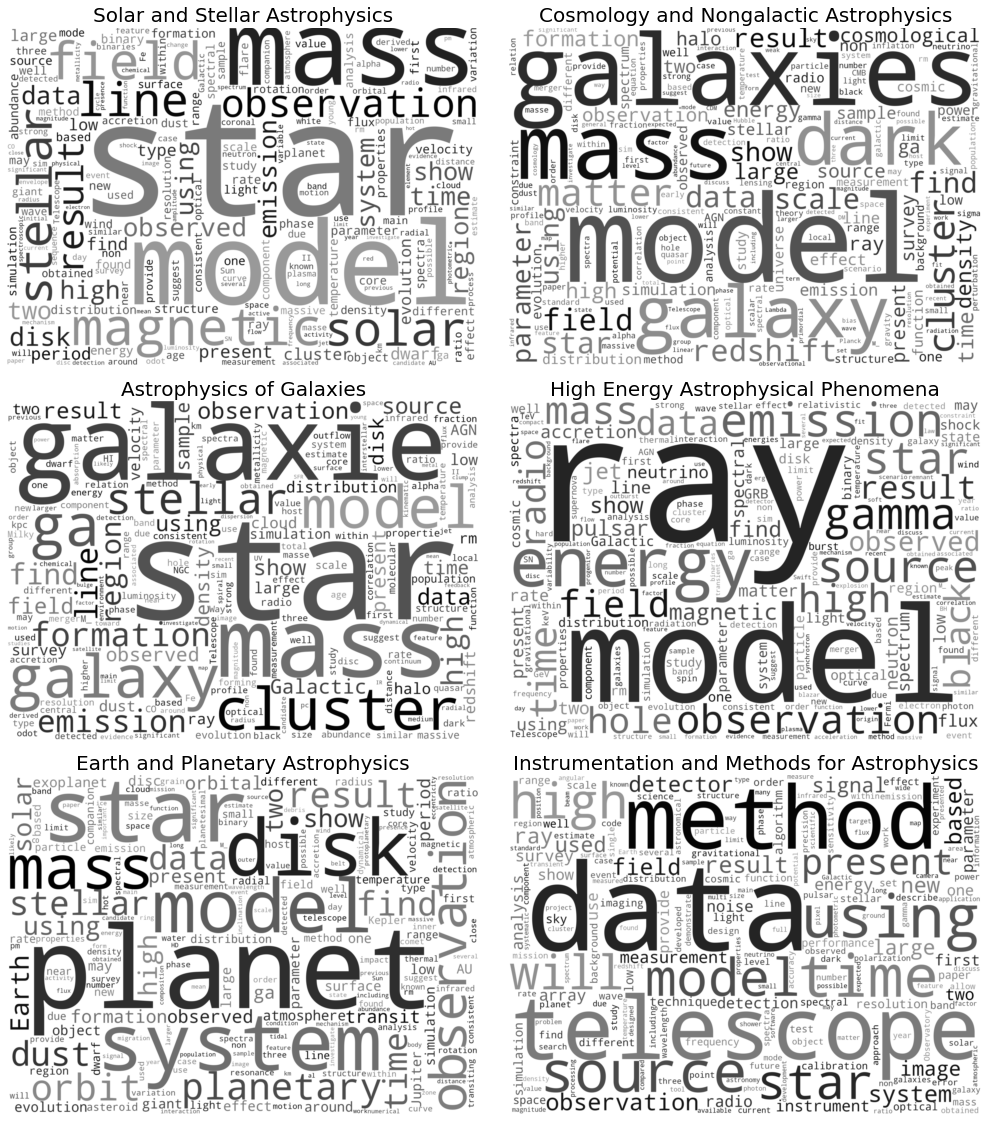

In [31]:
import random
fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(18, 20))
fig.subplots_adjust(hspace=0.1, wspace=0)

for i, ax in enumerate(axarr.reshape(-1)):
    ax.set_title(astrophysics_subcats[list(astrophysics_subcats.keys())[i]], fontsize=20)
    ax.axis('off')
    ax.imshow(clouds[i].recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")

## Year distribution

Length of abstracts

# 4. Fulltexts

Note that fulltexts include abstracts.

In [31]:
clouds = []

for subcat in astrophysics_subcats.keys():
    wc = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      collocations=False,
                      width=2500,
                      height=1800)
    counter = Counter()
    
    # Get ids of papers that have this subcategory
    paper_ids = corpus[corpus['subcategories'].apply(lambda x: 'astro-ph.CO' in x)]['filename_parsed']
    
    # Load these files iteratively (to optimize memory usage)
    for paper_id in paper_ids: 
        filepath = GLOBALS['absolute_filepaths']['corpus'] + 'fulltexts/and_stopword_removal/' + paper_id + '.npy'
        counter.update(np.load(filepath))
        
    cloud = wc.generate_from_frequencies(counter)
    clouds.append(cloud)
    break

In [19]:
def show_wordclouds(clouds):
    fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(18, 20))
    fig.subplots_adjust(hspace=0.1, wspace=0)

    for i, ax in enumerate(axarr.reshape(-1)):
        ax.set_title(astrophysics_subcats[list(astrophysics_subcats.keys())[i]], fontsize=20)
        ax.axis('off')
        ax.imshow(clouds[i].recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")

IndexError: list index out of range

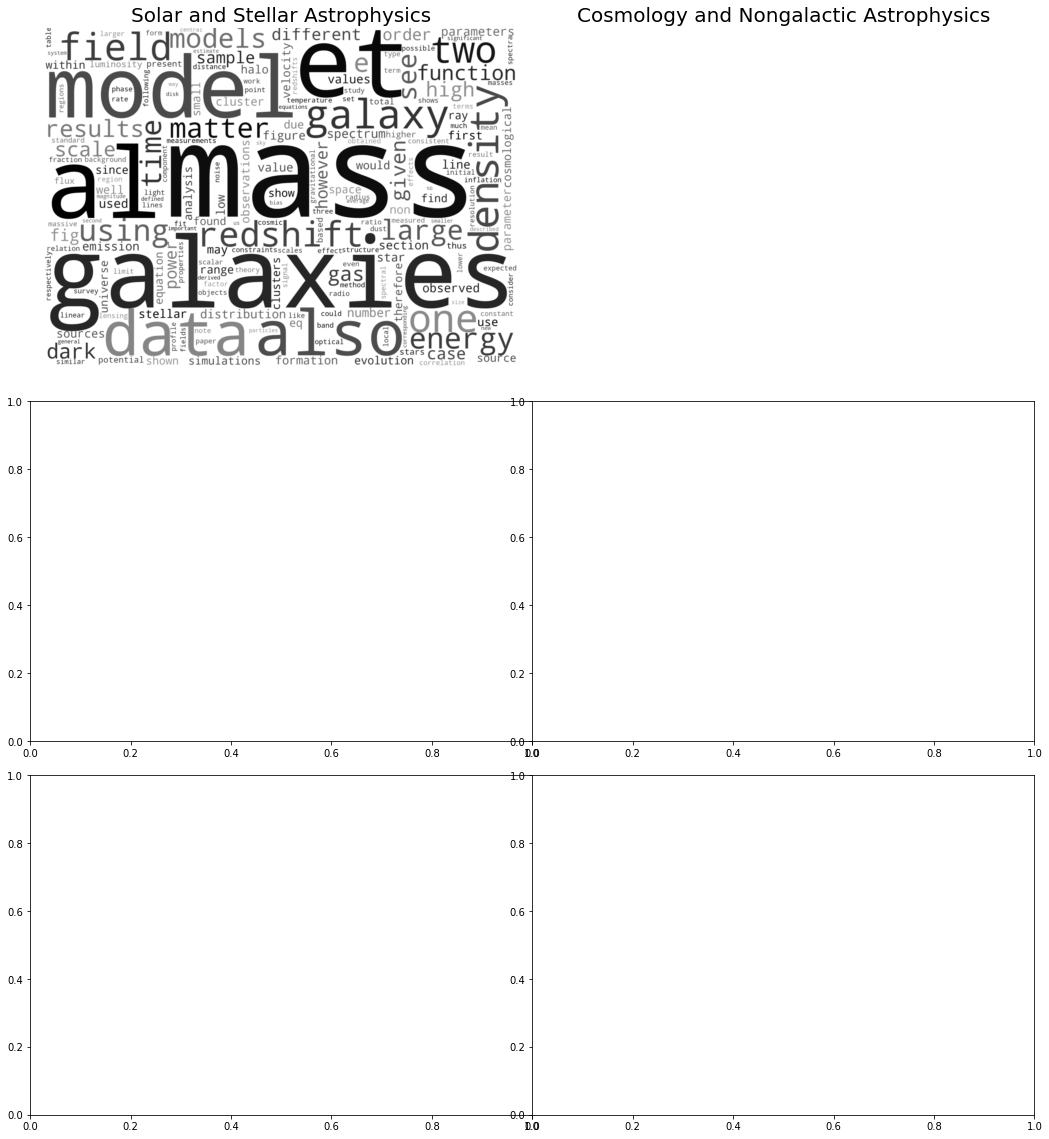

In [32]:
show_wordclouds(clouds)